Checking directory: D:/Random_Forest_Computer_Vision/dataset/0
Found 0 images in directory D:/Random_Forest_Computer_Vision/dataset/0
No images found in directory: D:/Random_Forest_Computer_Vision/dataset/0
Found 10773 images in directory D:/Random_Forest_Computer_Vision/dataset/0\0
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\0.png
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\1.png
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\10.png
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\100.png
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\1000.png
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\10000.png
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\10001.png
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\10002.png
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\10003.png
Loading image: D:/Random_Forest_Computer_Vision/dataset/0\0\10004.png
Loading image: D:/Random_Fores

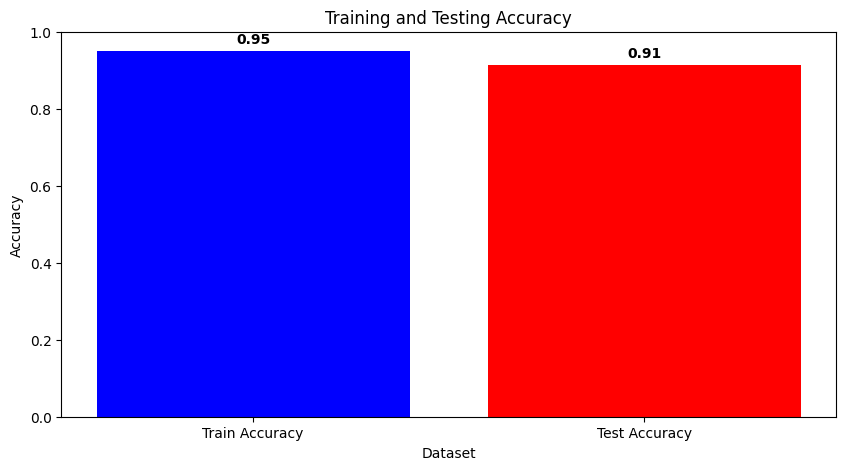

Model saved as random_forest_model.joblib


In [5]:
import os
import numpy as np
from PIL import Image
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt

# Đường dẫn đến thư mục chính
main_directory = "D:/Random_Forest_Computer_Vision/dataset"

# Hàm tải và tiền xử lý hình ảnh
def load_and_preprocess_images(main_directory, max_files_per_class=500):
    images = []
    labels = []
    
    for label in range(10):
        subdir_path = os.path.join(main_directory, str(label)).replace("\\", "/")
        print(f"Checking directory: {subdir_path}")
        
        if os.path.isdir(subdir_path):
            for root, dirs, files in os.walk(subdir_path):
                print(f"Found {len(files)} images in directory {root}")
                
                if not files:
                    print(f"No images found in directory: {root}")
                    continue
                
                # Giới hạn số lượng file để tránh quá tải bộ nhớ và giữ lại chất lượng mô hình
                files = files[:max_files_per_class]
                
                for file in files:
                    file_path = os.path.join(root, file)
                    print(f"Loading image: {file_path}")
                    image = Image.open(file_path)
                    
                    # Resize image to 28x28 pixels
                    image = image.resize((28, 28))
                    image_array = np.array(image)
                    
                    # Normalize pixel values to range [0, 1]
                    image_array = image_array / 255.0
                    
                    images.append(image_array)
                    labels.append(int(label))
        else:
            print(f"Directory not found: {subdir_path}")
    
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Tải và tiền xử lý hình ảnh
images, labels = load_and_preprocess_images(main_directory)

if images.size == 0:
    raise ValueError("No images were loaded. Please check the directory paths and image files.")
else:
    print(f"Total images loaded: {len(images)}")

# Làm phẳng các hình ảnh để sử dụng cho bộ phân loại Random Forest.
flattened_images = images.reshape(images.shape[0], -1)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra theo tỷ lệ 60-40
X_train, X_test, y_train, y_test = train_test_split(flattened_images, labels, test_size=0.4, random_state=42)

# Định nghĩa mô hình Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Định nghĩa các tham số cho GridSearchCV
param_grid = {
    'n_estimators': [10, 20],  
    'max_depth': [7, 9],  
    'min_samples_split': [8, 12], 
    'min_samples_leaf': [3, 5]
}

# Sử dụng GridSearchCV để tìm tham số tốt nhất
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Lấy mô hình tốt nhất từ GridSearchCV
best_rf_model = grid_search.best_estimator_

print(f"Best parameters found: {grid_search.best_params_}")

# Dự đoán trên tập huấn luyện và tập kiểm tra
train_pred = best_rf_model.predict(X_train)
test_pred = best_rf_model.predict(X_test)

# Tính toán độ chính xác
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

# Vẽ biểu đồ đường thẳng so sánh độ chính xác
plt.figure(figsize=(10, 5))
plt.bar(['Train Accuracy', 'Test Accuracy'], [train_accuracy, test_accuracy], color=['blue', 'red'])

plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.ylim([0, 1])  # Đặt giới hạn trục y từ 0 đến 1

# Hiển thị giá trị độ chính xác trên đồ thị
for i, v in enumerate([train_accuracy, test_accuracy]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.show()

# Kiểm tra nếu độ chính xác trên tập kiểm tra cao hơn 0.8 và lưu mô hình nếu đúng
if test_accuracy > 0.8:
    joblib.dump(best_rf_model, 'random_forest_model.joblib')
    print("Model saved as random_forest_model.joblib")
else:
    print("Model not saved. Accuracy less than 0.8")
